# Slice and Interpolate Image Data

In [1]:
import pathlib 
from collections import defaultdict

import h5py
import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm,Normalize
import matplotlib.cm as cm

from bluesky_tutorial_utils import nexus, fetch

/home/travis/virtualenv/python3.7.1/lib/python3.7/site-packages/pims/image_reader.py:26: RuntimeWarning: PIMS image_reader.py could not find scikit-image. Falling back to matplotlib's imread(), which uses floats instead of integers. This may break your scripts. 
(To ignore this warning, include the line "warnings.simplefilter("ignore", RuntimeWarning)" in your script.)
  warnings.warn(RuntimeWarning(ski_preferred))


In [2]:
# Un-comment this for better-looking plots on high-resolution screens.
# %config InlineBackend.figure_format = 'retina'

**We have taken the original data and reduced its precision significnatly so that it will download faster for teaching purposes.**

In [3]:
fetch.rsoxs_simulation_data();

## Working with a Single Image xArray

In [4]:
fname = './rsoxs_simulation_data/512-512-128-5.0-40.0-00285-0360.nxs'
da_img = nexus.read_singleimg_nxs(fname)
da_img_chi = nexus.read_singleimg_nxs(fname,sasdata='unwrap')
da_img

<xarray.DataArray 'I' (Qx: 512, Qy: 512)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float16)
Coordinates:
  * Qx       (Qx) float16 -0.6284 -0.626 -0.6235 -0.621 ... 0.6235 0.626 0.6284
  * Qy       (Qy) float16 -0.6284 -0.626 -0.6235 -0.621 ... 0.6235 0.626 0.6284
Attributes:
    lazy:     False

### Basic Slicing and Plotting 

First just a simple image plot on a log scale

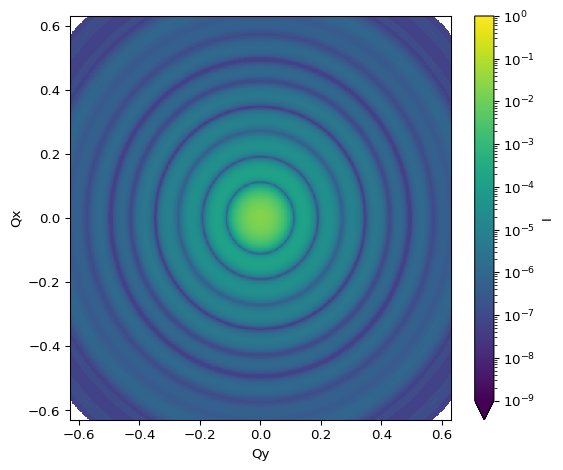

In [5]:
da_img.plot(norm=LogNorm(1e-9,1),aspect=1.2,size=5)

Comparison of nearest-pixel versus interpolated selection for a **horizontal line cut**

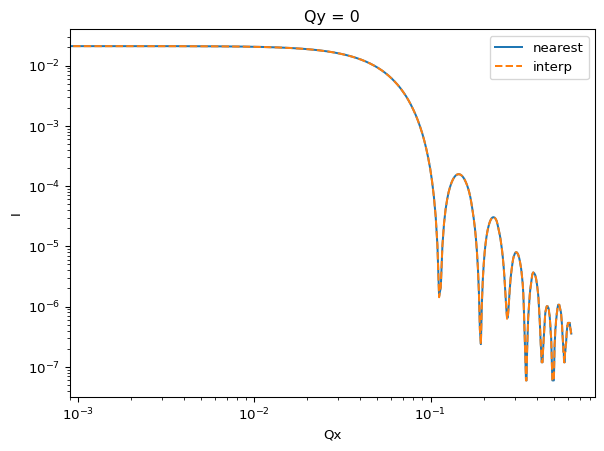

In [6]:
da_img.sel(Qy=0,method='nearest').plot(yscale='log',xscale='log',label='nearest')
da_img.interp(Qy=0).plot(yscale='log',xscale='log',label='interp', ls='--')
plt.legend()

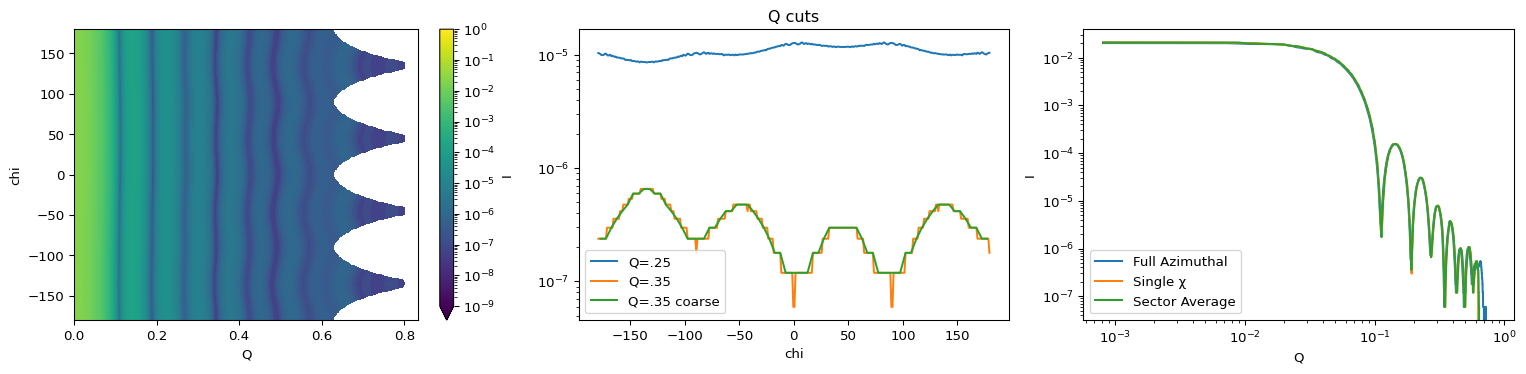

In [7]:
fig,axes = plt.subplots(1,3,figsize=(16,4))
da_img_chi.plot(norm=LogNorm(1e-9,1),ax=axes[0])
da_img_chi.sel(Q=0.25,method='nearest').plot(ax=axes[1], label='Q=.25')
da_img_chi.sel(Q=0.35,method='nearest').plot(ax=axes[1], label='Q=.35', yscale='log')

(da_img_chi.sel(Q=0.35,method='nearest')
          .coarsen({'chi':5})
          .mean()
          .plot(ax=axes[1],yscale='log', label="Q=.35 coarse"))

axes[1].legend()
axes[1].set_title("Q cuts")

da_img_chi.mean('chi').plot(ax=axes[2],xscale='log',yscale='log',label='Full Azimuthal')
da_img_chi.sel(chi=0,method='nearest').plot(ax=axes[2],xscale='log',yscale='log',label='Single χ')
da_img_chi.sel(chi=np.arange(-10,10,0.1),method='nearest').mean('chi').plot(ax=axes[2],xscale='log',yscale='log',label='Sector Average')
axes[2].legend()
plt.tight_layout()

### Remeshing

In [8]:
qx = np.linspace(-0.5,0.5,512)
qy = np.linspace(-0.5,0.5,512)
da_img_remesh = da_img.interp(Qx=qx,Qy=qy)
da_img_remesh

<xarray.DataArray 'I' (Qx: 512, Qy: 512)>
array([[2.00271606e-07, 2.38437242e-07, 2.47992648e-07, ...,
        2.88635784e-07, 2.50414160e-07, 2.40802765e-07],
       [2.38437242e-07, 2.38605062e-07, 2.86307295e-07, ...,
        2.98098168e-07, 2.98023370e-07, 2.50414160e-07],
       [2.47992648e-07, 2.86307295e-07, 2.95713105e-07, ...,
        3.36469387e-07, 2.98098168e-07, 2.88635784e-07],
       ...,
       [2.88635784e-07, 2.98098168e-07, 3.36469387e-07, ...,
        3.93763914e-07, 3.45986883e-07, 3.07597293e-07],
       [2.50414160e-07, 2.98023370e-07, 2.98098168e-07, ...,
        3.45986883e-07, 2.98209853e-07, 2.98041887e-07],
       [2.40802765e-07, 2.50414160e-07, 2.88635784e-07, ...,
        3.07597293e-07, 2.98041887e-07, 2.59876251e-07]])
Coordinates:
  * Qx       (Qx) float64 -0.5 -0.498 -0.4961 -0.4941 ... 0.4961 0.498 0.5
  * Qy       (Qy) float64 -0.5 -0.498 -0.4961 -0.4941 ... 0.4961 0.498 0.5
Attributes:
    lazy:     False

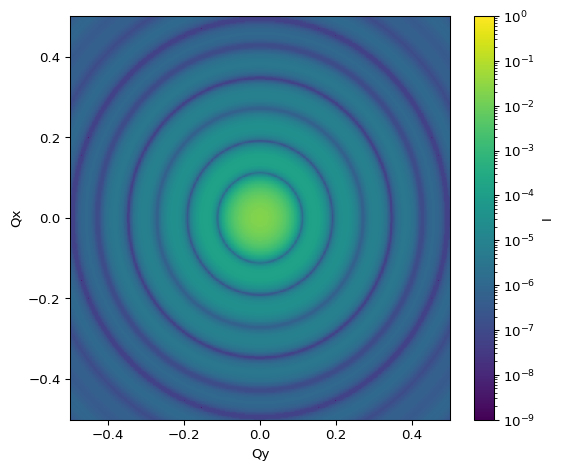

In [9]:
da_img_remesh.plot(norm=LogNorm(1e-9,1),aspect=1.2,size=5)